# Анализ оттока клиентов


# Ссылка на презентацию: https://disk.yandex.ru/i/DDu2yMKSw6QZpg 

**Описание проекта**

Менеджер банка «Метанпромбанк» попросил разобраться, какие клиенты уходят из банка. Анализ покажет, какие клиенты уходят из банка, а так же поможет нам составить сегменты клиентов, которые склонны уходить из банка.

**Цель проекта**

Составить портрет уходящего клиента. Дать рекомендации, которые помогут уменьшить отток клиентов.

**Описание данных**

Данные предоставлены из банка, находяшегося в Ярославле и областных городах: Ростов Великий и Рыбинск.

# Декомпозиция

**Приблизительные пункты, которые будут рассмотрены в исследовании:**
1. Обзор и предобработка данных
  - Проработать названия столбцов, привести их к одной стилистике.
  - Привести данные к нужному типу.
  - Проверить на пропуски. Решить что с ними сделать.
  - Проверить на явные дубликаты.
2. Анализ данных   
  - Как разные сегменты (пол, возраст, город, количество объектов в собственности, баланс на счете, заработная плата) связаны с оттоком клиентов. Построить графики, на которых будет показана зависимость между разными сегментами и оттоком клиентов.
  - Посчитать процент оттока клиентов в каждом сегменте.
  - Посмотреть распределение, какие группы можно объединить? (скорее всего, все графики будут посторены методом hist)
  - Построить матрицу корреляции данных.
3. Проверка гипотез.
  -  Проверить гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.
     - Нулевая: *Доход между клиентами, которые уши и которые остались, разный*
     - Альтернативная: *Доход между клиентами, которые уши и которые остались, одинаковый*
  - Сформулировать вторую гипотезу (нулевую и альтернативную).
4. Сделть общие выводы, сформулировать профиль уходящего клиента. Дать рекомендации по удержанию клиента.

После каждого пункта должны быть промежуточные выводы, соответсвующие ходу исследования.

## Обзор и предобработка данных 

In [2]:
# импорт библиотек

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
import math
import scipy.stats as stats
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np


pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Выгрузим файл

d = 'https://code.s3.yandex.net/datasets/bank_scrooge.csv'
bank = pd.read_csv(d)

#Посмотрим типы данных

bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [4]:
# Переименуем столбцы

bank = bank.rename(columns = {'USERID':'user_id', 'EST_SALARY':'est_salary'})

bank.head(7)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0


In [5]:
# Проверим количество пропусков и явных дубликатов

print('Пропуски:\n', bank.isna().sum())
print('Явные дубликаты:', bank.duplicated().sum())

Пропуски:
 user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64
Явные дубликаты: 0


In [6]:
age_duplicat = (bank['age'].isnull().sum() / len(bank)) * 100
balance_duplicat = (bank['balance'].isnull().sum() / len(bank)) * 100
print('Пропуски по возрасту', age_duplicat.round(10), '%')
print('Пропуски по балансу', balance_duplicat.round(2), '%')

Пропуски по возрасту 0.26 %
Пропуски по балансу 22.95 %


In [7]:
# Посмотрим в каких столбцах преобладает количество пропусков по возрасту

age_t = bank.loc[bank['age'].isnull()]
age_sum = age_t.pivot_table(index='user_id', aggfunc='count')
age_sum.sum()

age               0
balance          10
churn            26
city             26
credit_card      26
equity           26
est_salary       26
gender           26
last_activity    26
products         26
score            26
dtype: int64

In [8]:
# Удалим пропуски в стобце возраст

bank = bank.dropna(subset=['age'])
bank.isna().sum()

user_id             0
score               0
city                0
gender              0
age                 0
equity              0
balance          2279
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64

In [9]:
# Приведем столбцы к нужному типу 

bank['score'] = bank['score'].astype(int)
bank['age'] = bank['age'].astype(int)
bank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9974 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9974 non-null   int64  
 1   score          9974 non-null   int64  
 2   city           9974 non-null   object 
 3   gender         9974 non-null   object 
 4   age            9974 non-null   int64  
 5   equity         9974 non-null   int64  
 6   balance        7695 non-null   float64
 7   products       9974 non-null   int64  
 8   credit_card    9974 non-null   int64  
 9   last_activity  9974 non-null   int64  
 10  est_salary     9974 non-null   float64
 11  churn          9974 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1013.0+ KB


In [10]:
print('Количество уникальных значений в столбце user_id:', bank['user_id'].nunique())
print('Всего значений в столбце user_id:', bank['user_id'].count())

Количество уникальных значений в столбце user_id: 9924
Всего значений в столбце user_id: 9974


In [11]:
# Выведем клиентов у которых одинаковое id

user_dubl = bank[bank.duplicated(['user_id'], keep=False)]
user_dubl

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
58,164676,860,Ярославль,М,37,5,648594.03,2,1,1,213586.86,1
150,185748,850,Рыбинск,М,36,5,1203376.67,2,0,1,89401.82,1
161,197364,928,Рыбинск,Ж,53,6,1347183.86,2,0,1,168189.49,1
231,190253,823,Рыбинск,М,37,4,373348.39,2,0,1,131947.92,1
690,152479,768,Рыбинск,Ж,42,0,126787.79,4,1,1,143233.23,1
...,...,...,...,...,...,...,...,...,...,...,...,...
9659,195884,767,Рыбинск,Ж,45,1,335652.56,3,1,1,100197.67,0
9775,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0
9785,168998,895,Рыбинск,М,44,0,282653.53,3,0,0,255296.47,0
9880,217412,886,Ярославль,Ж,35,3,1026172.14,2,1,0,53099.16,0


**Промежуточный вывод:** Привела данные к нужному типу. Явных дубликатов не обнаружила. Нашла 50 клиентов у которых одинаковое id, но разные данные, что позволяет мне сделать вывод, что при сборе данных была сделана ошибка. Так же удалила пропуски по возрасту, тк их было всего ничего, это не повлияет на ход исследования. Обнаружила достаточно большое количество пропусков в столбце баланс, скорее всего ошибка так же при сборе данных.

## Анализ данных

In [11]:
# Посмотрим сколько всего клиентов ушло а сколько осталось 

churn_1 = bank[bank['churn'] == 1]['user_id'].count()
churn_0 = bank['user_id'].count() - churn_1
churn_sum = churn_1 + churn_0
percent_churn_1 = churn_1 * 100 / churn_sum
percent_churn_0 = churn_0 * 100 / churn_sum
print('Всего клиентов ушло:', churn_1, 'это', percent_churn_1.round(1),'%')
print('Всего клиентов осталось:', churn_0,'это', percent_churn_0.round(1),'%')

Всего клиентов ушло: 1819 это 18.2 %
Всего клиентов осталось: 8155 это 81.8 %


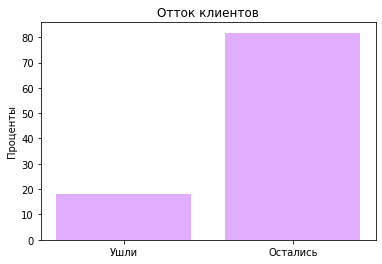

In [12]:
# Построим график общего оттока клиентов
y = ['Ушли', 'Остались']
x = [percent_churn_1, percent_churn_0]

plt.ylabel('Проценты')
plt.title('Отток клиентов')

plt.bar(y, x, color='#E1AEFF')
plt.show()

**Промежуточный вывод:** Всего клиентов которые ушли 1819 это 18.2%, от общего колличества.

### Как разные сегменты связаны с оттоком клиентов?

In [13]:
# Постоим таблицу как средние значения по столбцам распределяются между теми клиентами кто ушел, а кто остался 

bank.groupby('churn').agg('mean').round(1).T

churn,0,1
user_id,171928.1,170980.1
score,845.4,863.4
age,43.0,41.5
equity,2.4,3.8
balance,733031.6,1134458.2
products,1.8,2.4
credit_card,0.7,0.6
last_activity,0.5,0.7
est_salary,147674.6,148289.7


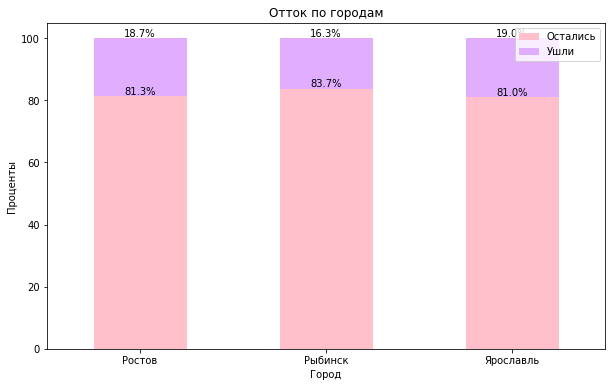

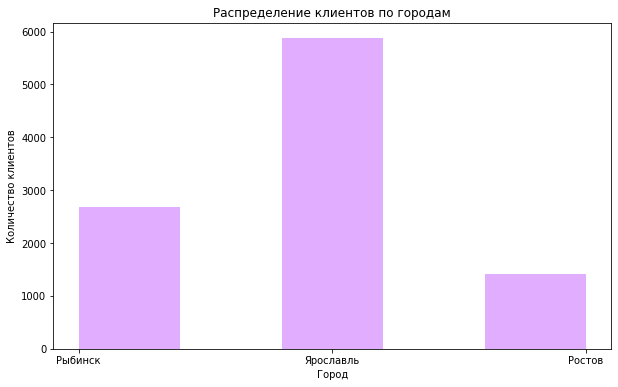

In [14]:
# Построим график оттока по городам

churn_city = bank.groupby('city')['churn'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["pink", '#E1AEFF'] 
churn_city.unstack().plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_xlabel('Город')
ax.set_ylabel('Проценты')
ax.set_title('Отток по городам')
ax.legend(title='Churn')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height), ha='center', va='bottom')

    plt.xticks(rotation=0)
plt.legend(['Остались', 'Ушли'])
plt.show()

# Построим график распределения клиентов по городам 

plt.figure(figsize=(10, 6))
plt.hist(bank['city'], bins=5, color='#E1AEFF')
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по городам')

plt.show()

**Промежуточный вывод:** Отток клиентов по городам не сильно различается, по сколько Ярославль достаточно большой город, в нем самый большой отток из за большей выборки 19,0%. Рыбинск занимает второе место и по количеству клиентов, но отток там самый маленкий 16,3%. Третье место, по количеству клиентов, занимает Ростов, по оттоку он находится на втором месте.

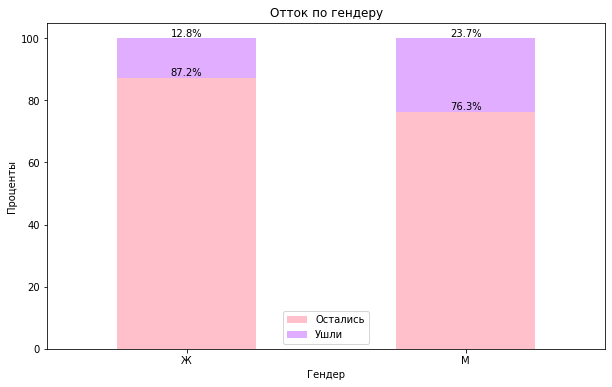

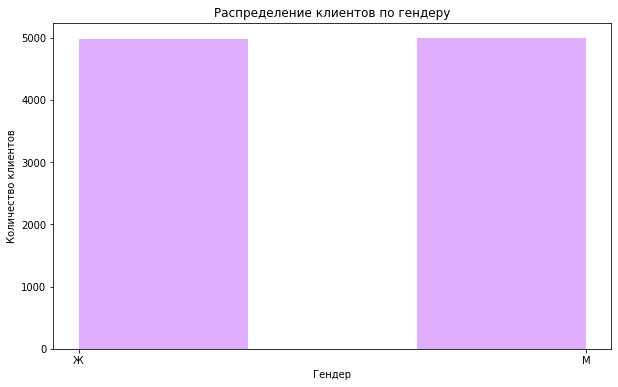

In [15]:
# Построим график оттока по гендеру

churn_gender = bank.groupby('gender')['churn'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["pink", '#E1AEFF'] 
churn_gender.unstack().plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_xlabel('Гендер')
ax.set_ylabel('Проценты')
ax.set_title('Отток по гендеру')
ax.legend(title='Churn')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height), ha='center', va='bottom')

plt.legend(['Остались', 'Ушли'])
plt.xticks(rotation=0)
plt.show()

# Построим график распределения клиентов по гендеру

plt.figure(figsize=(10, 6))
plt.hist(bank['gender'], bins=3, color='#E1AEFF')
plt.xlabel('Гендер')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по гендеру')

plt.show()

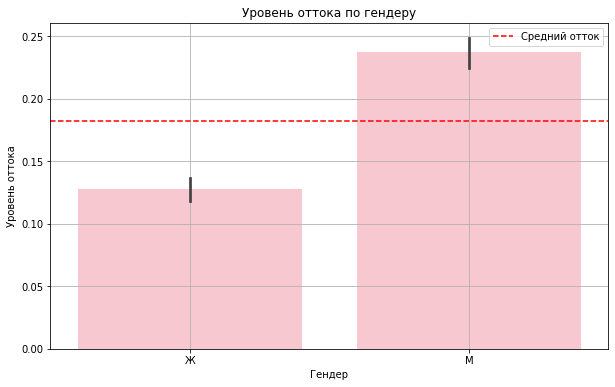

In [16]:


plt.figure(figsize=(10, 6))
sns.barplot(data=bank, x='gender', y='churn', color='pink')
plt.axhline(y=bank['churn'].mean(), color='red', linestyle='--', label='Средний отток')
plt.xlabel('Гендер')
plt.ylabel('Уровень оттока')
plt.title('Уровень оттока по гендеру')
plt.legend()
plt.grid(True)

plt.show()

**Промежуточный вывод:** Клиентов мужского и женского пола одинаковое количество. При этом клиенты мужского уходят чаще (23,7%), чем клиенты женского пола (12,8%)

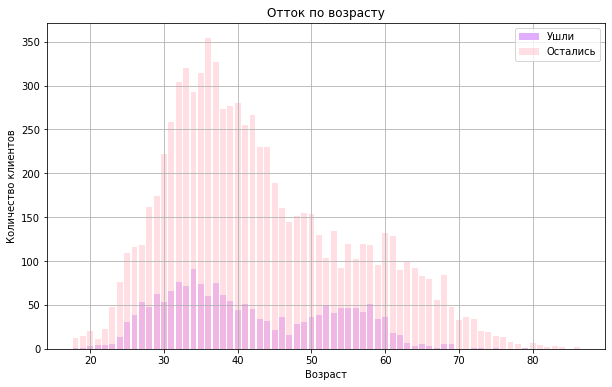

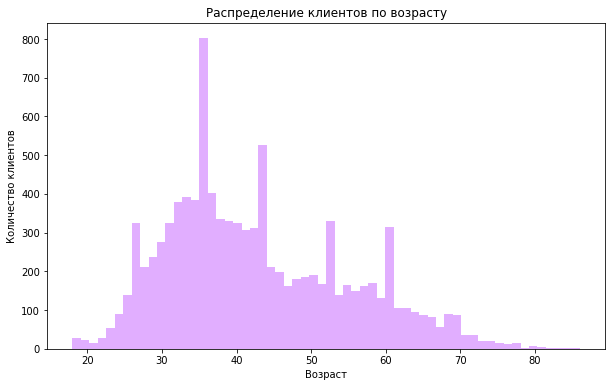

In [17]:
# Построим график оттока по возрасту 

churn_age = bank.groupby('age')['churn'].sum()
churn_age_0 = bank.groupby('age')['churn'].apply(lambda x: (x==0).sum())

plt.figure(figsize=(10, 6))
plt.bar(churn_age.index, churn_age.values, label='Ушли', color='#E1AEFF')
plt.bar(churn_age_0.index, churn_age_0.values, label='Остались', color="pink", alpha=0.5)
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.title('Отток по возрасту')
plt.legend()
plt.grid(True)

plt.show()

# Построим график распределения клиентов по возрасту

plt.figure(figsize=(10, 6))
plt.hist(bank['age'], bins=60, color='#E1AEFF')
plt.xlabel('Возраст')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по возрасту')

plt.show()

**Промежуточный вывод:** Клиенты по возрасту рапределены не равномерно, больше всего клиентов от 30 до 40 лет, меньше всего клиентов от 70 до 90 лет. Самый высокий отток так же наблюдается в возрастной группе 30-40 лет, 40-50 лет отток немного падает, после чего снова возрастает в группе 50-60 лет, но уже не так сильно как в группе 30-40.

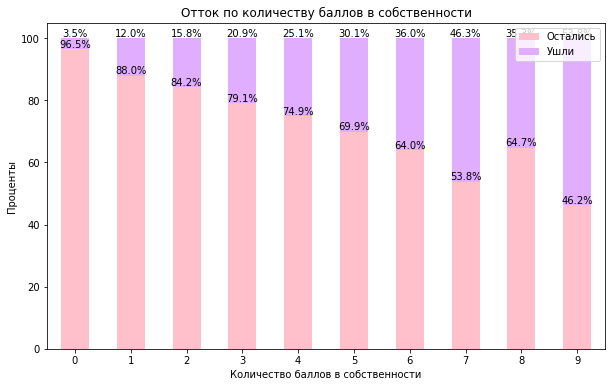

In [18]:
# Построим график по оттоку количества баллов собственности 

churn_equity = bank.groupby('equity')['churn'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["pink", '#E1AEFF'] 
churn_equity.unstack().plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_xlabel('Количество баллов в собственности')
ax.set_ylabel('Проценты')
ax.set_title('Отток по количеству баллов в собственности')
ax.legend(title='Churn')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height), ha='center', va='bottom')

plt.legend(['Остались', 'Ушли'])
plt.xticks(rotation=0)
plt.show()

**Промежуточный вывод:** Самый большой отток у клиентов которые имеют 9 баллов в собственности(53,8%). Второе место, 7 баллов - 46,3%. Третье место, 6 баллов - 36,0%

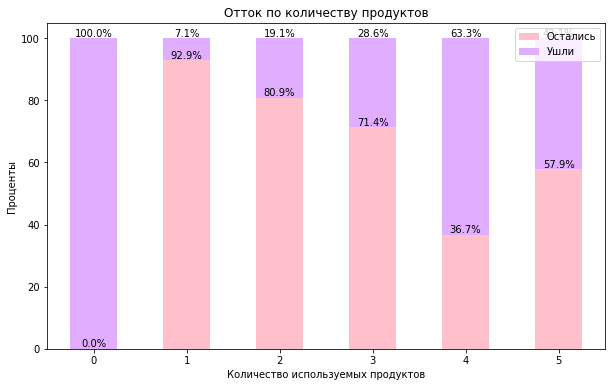

In [19]:
# Построим график по количеству продуктов

churn_products = bank.groupby('products')['churn'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["pink", '#E1AEFF'] 
churn_products.unstack().plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_xlabel('Количество используемых продуктов')
ax.set_ylabel('Проценты')
ax.set_title('Отток по количеству продуктов')
ax.legend(title='Churn')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height), ha='center', va='bottom')

plt.legend(['Остались', 'Ушли'])
plt.xticks(rotation=0)
plt.show()

**Промежуточный вывод:** 100% пользователей, кторые не используют продукты банка уходят, так же 63,3% процента клиентов использующих 4 продукта склонны к оттоку.

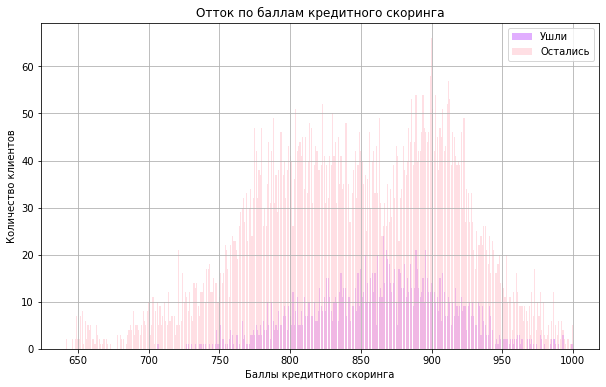

In [20]:
# Построим график оттока по баллам кредитного скоринга

churn_score = bank.groupby('score')['churn'].sum()
churn_score_0 = bank.groupby('score')['churn'].apply(lambda x: (x==0).sum())

plt.figure(figsize=(10, 6))
plt.bar(churn_score.index, churn_score.values, label='Ушли', color='#E1AEFF')
plt.bar(churn_score_0.index, churn_score_0.values, label='Остались', color="pink", alpha=0.5)
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Количество клиентов')
plt.title('Отток по баллам кредитного скоринга')
plt.legend()
plt.grid(True)

plt.show()

**Промежуточный вывод:** Чаще уходят клиенты, которые имеют баллы кредитного скоринга от 850  до 900. Меньне всего уходят клиенты у которых баллы от 600 до 750 и 950 до 1000.  

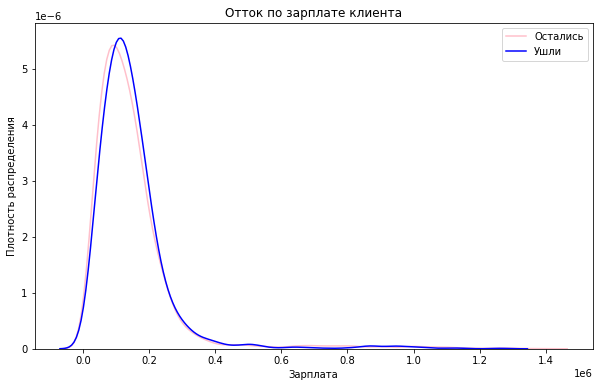

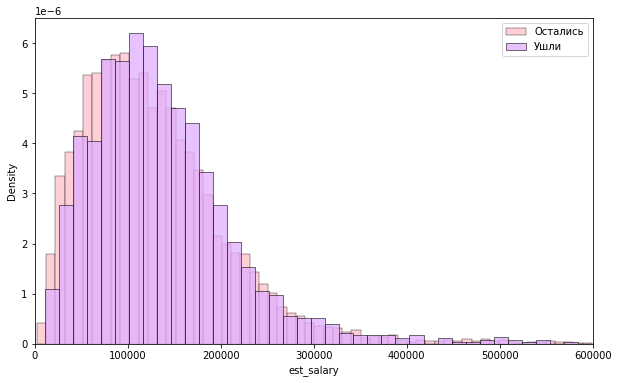

In [21]:
# Построим график оттока по зарплате клиента

churn_salary_0 = bank[bank['churn'] == 0]['est_salary']
churn_salary = bank[bank['churn'] == 1]['est_salary']

plt.figure(figsize=(10, 6))
sns.kdeplot(churn_salary_0, color='pink', label='Остались')
sns.kdeplot(churn_salary, color='blue', label='Ушли')

plt.xlabel('Зарплата')
plt.ylabel('Плотность распределения')
plt.title('Отток по зарплате клиента')
plt.legend()

plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(bank.query('churn == 0')['est_salary'], color='pink',stat='density', common_norm=False, label='Остались')
sns.histplot(bank.query('churn == 1')['est_salary'], color='#E1AEFF',stat='density', common_norm=False, label='Ушли')
plt.xlim(right=0.6e6)
plt.xlim(left=0)
plt.legend()
plt.show()

In [22]:
bank['churn_client'] = np.where(bank['est_salary'] < 100000, 'Неотток', 'Отток')

total = len(bank)

percent = bank['churn_client'].value_counts() / total * 100

print('Процент неоттока:', percent['Неотток'].round(2))
print('Процент оттока:', percent['Отток'].round(2))

Процент неоттока: 39.35
Процент оттока: 60.65


**Промежуточный вывод:** Клиенты у которых зарплата больше 100000 уходят чаще. Процент оттока 60.65

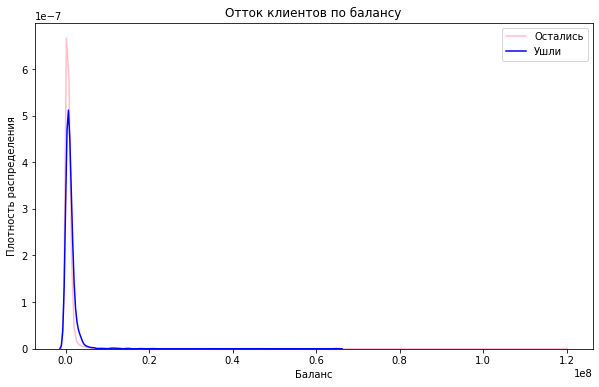

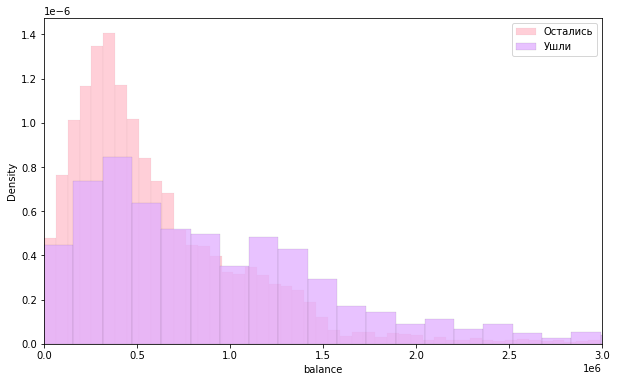

In [23]:
# Построим график оттока по балансу

churn_balance_0 = bank[bank['churn'] == 0]['balance']
churn_balance = bank[bank['churn'] == 1]['balance']

plt.figure(figsize=(10, 6))
sns.kdeplot(churn_balance_0, color='pink', label='Остались')
sns.kdeplot(churn_balance, color='blue', label='Ушли')

plt.xlabel('Баланс')
plt.ylabel('Плотность распределения')
plt.title('Отток клиентов по балансу')
plt.legend()

plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(bank.query('churn == 0')['balance'], color='pink', stat='density', common_norm=False, label='Остались')
sns.histplot(bank.query('churn == 1')['balance'], color='#E1AEFF', stat='density', common_norm=False, label='Ушли')
plt.xlim(right=3e6)
plt.xlim(left=0)
plt.legend()
plt.show()

In [24]:
bank['churn_client_balance'] = np.where(bank['balance'] < 100000, 'Неотток', 'Отток')

total_clients = len(bank)

churn_percent = bank['churn_client_balance'].value_counts() / total_clients * 100

print('Процент неоттока:', churn_percent['Неотток'].round(2))
print('Процент оттока:', churn_percent['Отток'].round(2))

Процент неоттока: 3.86
Процент оттока: 96.14


**Промежуточный вывод:** клиенты, у которых на счету больше 1000000 уходят чаще. Процент оттока 96.14

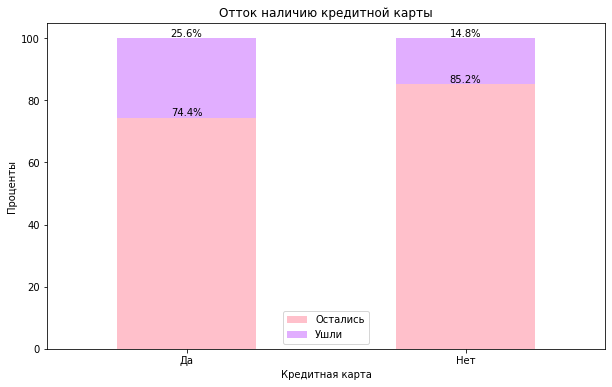

In [25]:
# Построим график оттока по наличию кредитной карты
bank['credit_card_1'] = bank['credit_card'].replace({1: 'Нет', 0: 'Да'})

churn_credit_card = bank.groupby('credit_card_1')['churn'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["pink", '#E1AEFF'] 
churn_credit_card.unstack().plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_xlabel('Кредитная карта')
ax.set_ylabel('Проценты')
ax.set_title('Отток наличию кредитной карты')
ax.legend(title='Churn')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height), ha='center', va='bottom')

plt.legend(['Остались', 'Ушли'])
plt.xticks(rotation=0)
plt.show()

**Промежуточный вывод:** Те, у кого есть кредитная карта уходят чаще (25,6%).

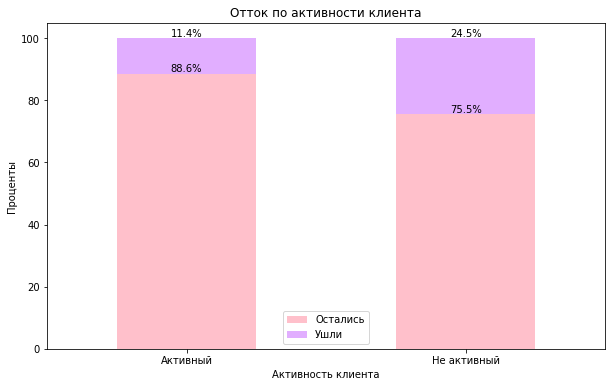

In [26]:
# Построим график оттока по активности клиента
bank['last_activity_1'] = bank['last_activity'].replace({1: 'Не активный', 0: 'Активный'})

churn_last_activity = bank.groupby('last_activity_1')['churn'].value_counts(normalize=True) * 100

fig, ax = plt.subplots(figsize=(10, 6))
colors = ["pink", '#E1AEFF'] 
churn_last_activity.unstack().plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_xlabel('Активность клиента')
ax.set_ylabel('Проценты')
ax.set_title('Отток по активности клиента')
ax.legend(title='Churn')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.1f}%', (x + width/2, y + height), ha='center', va='bottom')

plt.legend(['Остались', 'Ушли'])
plt.xticks(rotation=0)
plt.show()

**Промежуточный вывод:** Не активные клиенты уходят чаще (24,5%)

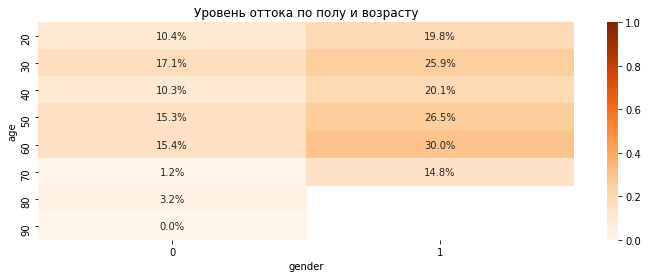

In [34]:
# Смотрим пару показателей пол-возраст
plt.figure(figsize=(12, 4))
sns.heatmap(bank.assign(
                age = bank.age.round(-1))\
            .pivot_table(
                index='age',
                columns='gender',
                values='churn',
                aggfunc='mean'), 
            cmap='Oranges', annot=True, fmt='.1%',vmin=0, vmax=1)
plt.title('Уровень оттока по полу и возрасту')
plt.show()

### Матрица корреляции

In [27]:
#bank['gender'] = bank['gender'].map({'М':1, 'Ж':0})
#bank['city_1'] = bank['city'].map({'Ярославль':0, 'Рыбинск':1, 'Ростов':2})
bank_1 = pd.get_dummies(bank)

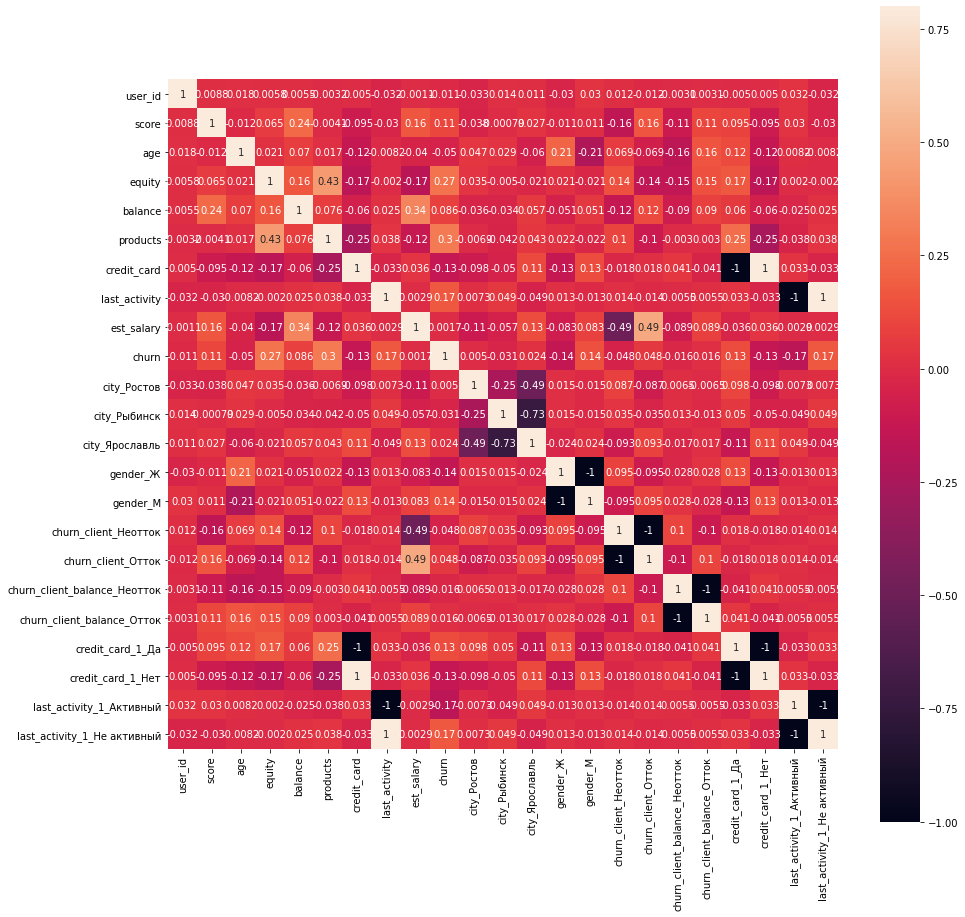

In [28]:
#corr_m = bank.drop(['user_id', 'city_1'], axis=1).corr()

plt.figure(figsize = (15,15))
sns.heatmap(bank_1.corr(), square=True, vmax=0.8, annot = True)

plt.show()


**Промежуточный вывод:** Высокая корреляция обратной свяи (-0.73) наблюдается у связи Рыбинск - Ярославль, так же умеренная (-0.49) у связи Ярославь - Ростов, у связи продукты и количество баллов в собственности(0.43), баланс - зарплата(0.34). Во всех остальных сегментах слабая корреляция.

## Проверка гипотез 

### Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались.

- **Нулевая:** Различий в среднем доходе между клиентами, которые остались, и клиентами, которые ушли, нет
- **Альтернативная:** Средний доход различается между клиентами, которые остались, и клиентами, которые ушли

Критический уровень статистической значимости alpha = 0.05

In [29]:
alpha = 0.05 

In [30]:
array1 = bank.loc[bank['churn'] == 0, 'est_salary']
array2 = bank.loc[bank['churn'] == 1, 'est_salary']

results = st.ttest_ind(array1, array2)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.8647861589211189
Не получилось отвергнуть нулевую гипотезу


**Промежуточный вывод:** Различий в среднем доходе между клиентами, которые остались, и клиентами, которые ушли, нет

### Проверка гипотезы влияния пола на отток клиентов

- **Нулевая:** Средний отток у межчин и женщин одинаковый
- **Альтернативная:** Средний отток у межчин и женщин разный

Критический уровень статистической значимости alpha = 0.05

In [31]:
bank['gender'] = bank['gender'].map({'М':1, 'Ж':0})

array3 = bank.loc[bank['gender'] == 0, 'churn']   
array4 = bank.loc[bank['gender'] == 1, 'churn']
        

results = st.ttest_ind(array3, array4)
    
print('p-значение:', results.pvalue)
    
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.29429008630903e-46
Отвергаем нулевую гипотезу


**Промежуточный вывод:** средний отток у мужчин и женщин разный 

В обоих гипотезах выборки достаточно большие и независимые, поэтому мы можем использовать критерий Стьюдента

In [32]:
columns = ['Профиль клиента', 'Город', 'Пол', 'Возраст', 'Баллы в собственности', 'Количество продуктов', 'Скоринг', 'Зарплата', 'Баланс', 'Кредитная карта', ' Активность клиента']
df = pd.DataFrame(columns=columns)
df.loc[0] = ['Отточный', 'Ростов', 'Мужской', '30-40 лет', '6-9', '0 и больше 4', '850-900', 'Больше 100000', 'Больше 100000', 'Есть', 'Не активный']
df.loc[1] = ['Неотточный', 'Рыбинск', 'Женский', '40-50 лет', '0-5', '1-3', '600-750, 950-1000', 'До 100000', 'До 100000', 'Нет', 'Активный']

## Выводы и рекомендации

Всего клиентов 9974,ушли из них 1819 это 18.2%

**Профиль клиента, который ушел:**
- Город - Ростов (отток - 18.7%)
- Пол - Мужской (отток - 23.7%)
- Возраст от 30 до 40 лет
- Имееет больше 6 баллов в собственности (самый большой отток у те кто имеет 9 баллов - 53%)
- Не пользуется продуктами банка или использует больше 4 (100% отток у тех кто не пользуется)
- Имеет от 850 до 900 баллов кредитного скоринга
- Получает зарпалату примерно 100000р (отток - 60.65%)
- Имеет баланс больше 100000р (отток - 96.14%)
- Имеет кредитную карту (отток - 25.6%)
- Является не активным клиентом (отток - 24.5%)

In [33]:
df

,Профиль клиента,Город,Пол,Возраст,Баллы в собственности,Количество продуктов,Скоринг,Зарплата,Баланс,Кредитная карта,Активность клиента
0,Отточный,Ростов,Мужской,30-40 лет,6-9,0 и больше 4,850-900,Больше 100000,Больше 100000,Есть,Не активный
1,Неотточный,Рыбинск,Женский,40-50 лет,0-5,1-3,"600-750, 950-1000",До 100000,До 100000,Нет,Активный


Так же были проверены две гипотезы: 
- Гипотеза различия дохода между теми клиентами, которые ушли и теми, которые остались. Проверка гипотезы показала что различий в среднем доходе между клиентами, которые остались, и клиентами, которые ушли, нет
- Гипотеза влияния пола на отток клиентов. Она показала, что средний отток у мужчин и женщин разный

Матрица корреляции показала нам, что высокая корреляция обратной свяи (-0.73) наблюдается у связи Рыбинск - Ярославль, так же умеренная (-0.49) у связи Ярославь - Ростов, у связи продукты и количество баллов в собственности(0.43), баланс - зарплата(0.34). Во всех остальных сегментах слабая корреляция.

**Рекомендации:**
- Увеличить продажи продуктов банка, чтобы каждый клиент использовал от 1 до 3 продуктов банка
- Стоит обратить внимание на возрастной сегмент от 40 до 50 лет, в этом сегменте не такой большой процент оттока.
- Баллы кредитного скоринга у идеального клиента должны быть 750 - 800.